***
# HCI Week 4 - Coronagraphs Part II
*Matthew Kenworthy // Leiden Observatory*

***

Today we cover encircled energy plots and look at telescope PSFs after simulating several coronagraphs.


<div class="alert alert-block alert-info">
<b>IMPORTANT:</b> It is okay to cut and paste and reuse code from your previous practica! I am not expecting you to type everything out again. You now have developed your own codes and plotting routines, please reuse them if you can. This is what most researchers do from day to day.</div>


Today, in [*Questions 4.1*](#part1) *- 4.4*, we will continue calculations to obtain the encircled energy as a function of radius for telescope pupil. You will take a look at different telescope PSFs.

Thereafter, in [*Questions 4.5*](#part2) *- 4.10*, we will simulate different (types/set-ups of) coronographs. 
> *Type 1: Vortex (focal plane) coronagraph*<br>
> *Type 2: The Vortex coronagraph with a secondary obscuration*<br>
> *Type 3: The Apodizing Phase Plate coronagraph*


<div class="alert alert-block alert-info">
<b>Tip:</b> As always, read through the functions defined in the block below, as they may help with the exercises.</div>

Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def displC(c, title="Amplitude-Phase space of the PSF", trim=0, show=True):
    """displC(c,trim=0) - display a Complex number c as four plots
    
               The top two plots are (Real, Imaginary) quantities
               The bottom two plots are (Amplitude, Phase)
               
               Optionally cut out the central square  with a size of 'trim x trim' pixels"""   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = int((nx-trim) / 2 + 1)
        dy = int((nx-trim) / 2 + 1)
        c2 = c[dx:dx+trim,dy:dy+trim]

    fig, ((axre, axim), (axamp, axpha)) = plt.subplots(nrows=2, ncols=2,
                         constrained_layout=True,
                         sharex=True,
                         sharey=True,
                         figsize=(12, 12))
    
    # plot out the panels
    im = axre.imshow(c2.real)
    plt.colorbar(im, ax=axre, fraction=0.046, pad=0.04, label="")
    im = axim.imshow(c2.imag)
    plt.colorbar(im, ax=axim, fraction=0.046, pad=0.04, label="")
    im = axamp.imshow(np.abs(c2))
    plt.colorbar(im, ax=axamp, fraction=0.046, pad=0.04, label="")
    im = axpha.imshow(np.angle(c2))
    plt.colorbar(im, ax=axpha, fraction=0.046, pad=0.04, label="")
    

    axre.set_title('Real')
    axre.set_ylabel('y [px]')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axamp.set_xlabel('x [px]')
    axamp.set_ylabel('y [px]')
    axpha.set_title('Phase')
    axpha.set_xlabel('x [px]')
    plt.suptitle(title, fontsize=18)
    if show:
        plt.show()

    
def plotCAmpl(Iorig, GAMMA=4, RANGE=None, plotnow=True, trim=0, title="plotCAmpl output"):
    """plotCAmpl - display a complex valued image by taking a complex 2D array 
        as input and returning an [N,3] RGB image for display

        if RANGE=(min,max) is given, it will set image intensity
        to 0 and 1 for these values and BLACK and WHITE
        colours for out of range amplitude values respectively

        the returned image has AMPLITUDE as brightness and
        PHASE as colour:

        RED    YELLOW   BLUE   GREEN
        0        90     180     270  degrees phase

        The image is scaled by a GAMMA factor (defaults to 4)
        to emphasize smaller amplitudes

        Set plotnow=False to stop display

        Returns a MxNx3 image suitable for display
    """
    import numpy as np
    PI = 4 * np.arctan(1)
    I = np.copy(Iorig)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = I.shape
        dx = int((nx-trim) / 2)
        dy = int((nx-trim) / 2)
        I = I[dx:dx+trim,dy:dy+trim]
        
    # calculate amplitude
    ampl = (abs(I)).real

    if RANGE is None:
        ampl = ampl / np.amax(ampl)
    else:
        ampl = (ampl - RANGE[0]) / abs(RANGE[1] - RANGE[0])
        ampOVER  = (ampl > 1)
        ampUNDER = (ampl < 0)
        ampl[ampOVER]  = 1
        ampl[ampUNDER] = 0

    # apply gamma to amplitude
    ampl = np.power(ampl, 1./GAMMA)

    # normalise phase from 0 to 1
    phse = (np.angle(I) / (2*PI)) + 0.5

    # make an RGB array
    img = np.zeros((I.shape[0], I.shape[1], 3), dtype=float)

    # red
    red = abs(phse - 0.625) * 4 - 0.5
    red = np.maximum(red, 0)
    red = np.minimum(red, 1)

    # green
    grn = 2 - abs(phse - 0.5) * 4
    tmp = np.where(grn > 1)
    grn[tmp] = 2. - grn[tmp]

    # blue
    blu = 1 - abs(phse - 0.5) * 4
    blu = np.maximum(blu, 0)

    img[:,:,0] = ampl * red
    img[:,:,1] = ampl * grn
    img[:,:,2] = ampl * blu
    
    titles = ['red', 'green', 'blue', 'rgb image']

    # mark out of range points with RGB color
    if RANGE:
        img[ampOVER,:]  = (1,1,1)
        img[ampUNDER,:] = (0,0,0)


    if plotnow:
        # modified for ipython notebooks
        fig, ax = plt.subplots(1, figsize=(6,6)) 
        ax.set_xlabel("x");   ax.set_ylabel("y")  
        ax.set_title("{}".format(title))
        ax.imshow(img, aspect='equal',vmin = 0., vmax = 1., interpolation='nearest')

        
    return(img)   
    
    
def padcplx(c,pad=5):
    """padcplx - puts a `Complex` array into the centre of a zero-filled `Complex` array
               pad is an integer defining the padding multiplier for the output array """
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = int((nx * (pad-1)) / 2)
    dy = int((ny * (pad-1)) / 2)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out a complex Fourier transform (with optional padding)
            c - the input 2D Complex numpy array
            pad - integer multiplier for the padding/sampling
            Returns the `Complex` FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(cb,pad=5):
    """IFFT - carry out the complex Fourier transform (with optional padding)
            and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfB = fftshift(ifft2(ifftshift(padcplx(cb,pad))))
    return psfB

def circle_mask(im, xc, yc, rcirc):
    """circle_mask - function that takes the input 2D array 'im' that evaluates the equation 
            (x-x_c)^2 + (y-y_c)^2 < r^2 with circle center coordinates (x_c, y_c) and a radius 'r'
            as input parameters and return a mask array with the same shape as 'im'."""
    # oof if I throw in in here this produces unexpected results so I changed it
    ny, nx = im.shape
    y,x = np.mgrid[0:nx,0:ny]
    r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
    return ( (r < rcirc))

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc#.astype('int')
    xp = xp - xc#.astype('int')
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    """phi_ramp - make an X-ramp, making the 0 be in the middle, 
            make it -0.5 to +0.5 and make it -pi to +pi. """
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def coro(A, m, N, nsamp):
    """coro - simulated Lyot coronograph taking a telescope pupil 'A', transmissive masks 'm' and 'N'
            and a sampling number 'nsamp' that returns  the final science camera focal plane image 'F' 
            and all the intermediate planes, 'B', 'C', 'D', and 'E'."""
    B = FFT(A,nsamp)
    C = m * B
    D = IFFT(C,1)
    E = N * D
    F = FFT(E,1)

    return(B,C,D,E,F)

def zoom(im, trim):
    cx, cy = (np.array(im.shape) / 2).astype('int')
    return im[cx-trim:cx+trim, cy-trim:cy+trim]

In [2]:
# you can use your own routines if you prefer
def Isum(c):
    """Isum - routine that calculate the summed (real) intensity of a complex amplitude input image, c"""
    return (np.sum(c * c.conjugate()).real)

def xaxis_energy(im, xr):
    """xaxis_energy - takes a complex image im, cuts out the line of pixels from -xr to +xr
            across the middle of the image and returns the energy per pixel along that line"""
    ny, nx = im.shape
    xc = int((nx-1) / 2.)
    yc = int((ny-1) / 2.)
    sli = im[yc,xc-xr:xc+xr+1]
    return((sli*np.conjugate(sli)).real)

def ee(im, xc, yc, r_ap):
    """ee - calculate the fraction of encircled energy within a circular aperture of radius 'r_ap'
            centered at (xap, yap) in the complex imput image 'im'. Returns encircled energy"""
    r, t = r_theta(im, xc, yc)
    
    eout = np.zeros_like(r_ap)
    for i, rnow in enumerate(r_ap):
        eout[i] = Isum(im * (r < rnow))
    return(eout)
    

In [3]:
def get_psf(img, phase):
    E = img * np.exp(1j*phase)
    Edet = FFT(E, 5)
    return np.abs(Edet)*np.abs(Edet)

<a id='part1'></a>

## Encircled Energy (continued from last week)
Last week you calculated the PSF profile and encircled energy for filled circular telescope pupils. Recall that the encircled energy is the *fraction of the total integrated flux in an image contained within a given radius r*.

Many telescopes have a large primary mirror that reflects the light onto a secondary mirror, which then forms the focus of the telescope at either a Cassegrain, Gregorian, or Naysmith focus. The secondary mirror blocks light from the centre of the primary telescope, along with the shadows of the secondary support struts that hold the secondary mirror above the primary mirror. This is referred to as the *secondary obscuration*.

Let us take a look at the encircled energy for secondary obscurations. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.1</span> <span style="  font-size:1em; color: SteelBlue;">
(6 points): </span>

**Calculate encircled energy plots for 0, 15, and 30 percent secondary obscuration in the center of the telescope pupil.**


<div class="alert alert-block alert-info">
<b>Tip 1:</b> With a 10 percent secondary obscuration we mean that the diameter of the secondary obscuration is 10% of the diameter of the primary mirror  </div>

1. **Assume the same telescope pupil geometry as previous week: a square array `A` with the pupil touching all four edges of the square, only now with a diameter of 101 pixels. The total intensity of `A` should be `100.0` intensity units.**
* **Assume the secondary obscuration is circular and concentric with the telescope pupil. The obscuration is completely opaque which implies it had an amplitude of zero.** 
* **For each telescope pupil: normalise the intensity in pupil A to 1 before transforming it to `B`. Recall that `B` is the first coronagraphic focal plane.**
* **Calculate and (over)plot the encircled energy for all secondary obscurations in one single plot with the x-asis ranging from 0 to 11 $\lambda/D$.**


<div class="alert alert-block alert-info">
<b>Tip 2:</b> Start from a radius of 1 pixel to avoid a divide by zero error. </div>




**Answer the question: What is the encircled energy at 1.22 $\lambda/D$ for all three (0, 15, and 30 percent) secondary obscuration sizes? Drawing a vertical line might be usefull to obtain the values**

---

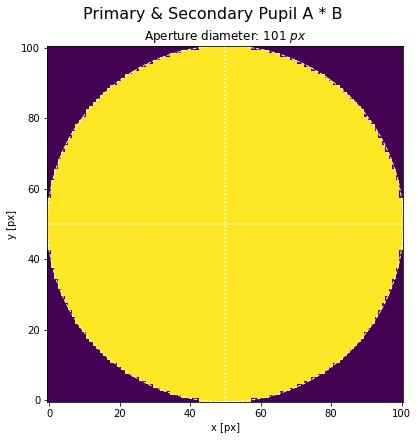

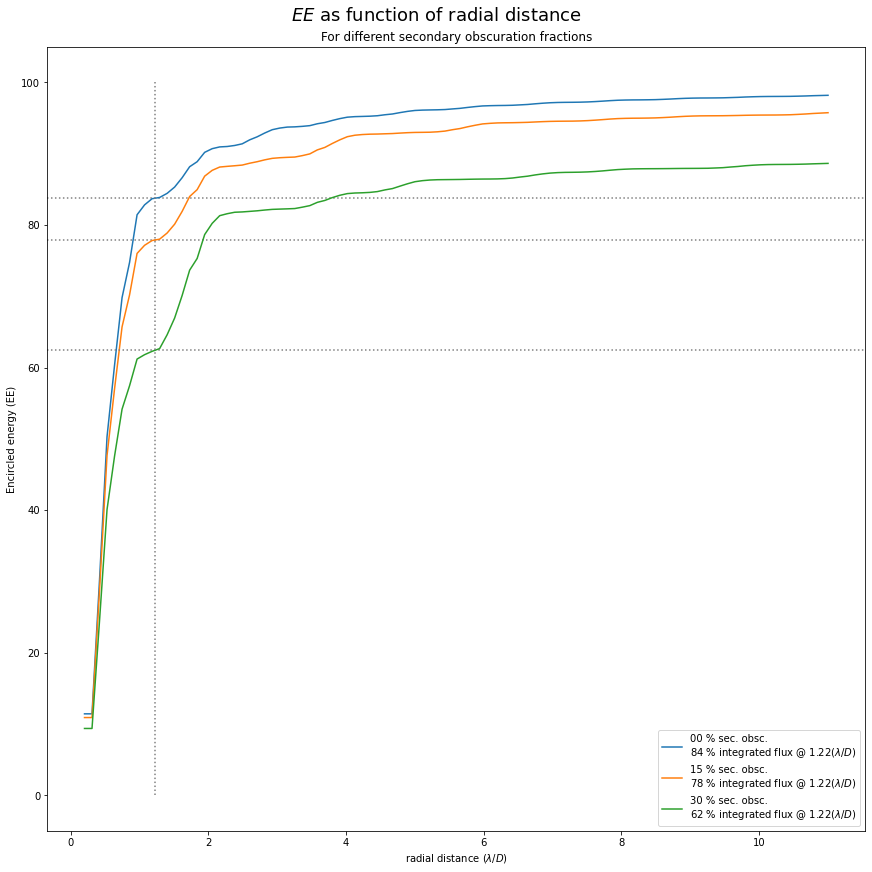

In [4]:
# Q1 code here
nsamp = 5 # use default
dtel = 101
norm = 100
xc, yc = (dtel-1)//2, (dtel-1)//2

# Q1 answer here

phase = np.zeros((dtel, dtel))
A = circle_mask(phase, (dtel-1)/2, (dtel-1)/2, dtel/2)
A = A * np.exp(1j*phase) 

frac = 0.0
rad = (dtel * frac) /2
B_mask = 1 - circle_mask(phase, (dtel-1)/2, (dtel-1)/2, rad)



fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(6, 6))
im = plt.imshow(np.abs(A * B_mask))
ax.axvline((dtel-1)/2, c="w", ls="dotted")
ax.axhline((dtel-1)/2, c="w", ls="dotted")

p = mpl.patches.Circle(((dtel-1)/2, (dtel-1)/2), dtel/2, fc="none", ec="w", ls="dashed")
ax.add_artist(p)

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title(r'Aperture diameter: $101~px$') 
fig.suptitle(r'Primary & Secondary Pupil A * B', fontsize=16)
plt.show()

# A = A * np.sqrt(norm / Isum(A))
A_n = A * np.sqrt(100 / Isum(A))

# ===============================

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))


fractions = np.array([0., 0.15, 0.3])
d_apperatures = np.linspace(1, 11 * nsamp, 100)

enen = []

for frac in fractions:
    B_mask = 1 - circle_mask(phase, (dtel-1)/2, (dtel-1)/2, frac * dtel/2)
    E = A_n * B_mask *np.exp(1j*phase) 
    Edet = FFT(E, nsamp)
    ASF = np.abs(Edet) * np.abs(Edet)
    B = np.abs(ASF)
    Bn = np.sqrt(B / np.product(np.array(A_n.shape)*nsamp))
    
    
    EE = ee(Bn, *np.array(Bn.shape)/2, d_apperatures)

    # units
    units = d_apperatures / nsamp

    fraction = ee(Bn, *np.array(Bn.shape)/2, [1.22 * nsamp])[0] / norm
    enen.append(fraction)
    ax.axhline(fraction * 100, c="gray", ls="dotted")
    ax.plot(units, EE, label=f"{frac* 100:02.0f} % sec. obsc. \n{fraction * 100:02.0f} % integrated flux @ "r"$1.22(\lambda/D)$")
    
ax.legend()
ax.plot(np.array([1.22, 1.22]), np.array([0, 100]), c="gray", ls="dotted")

ax.set_title(f'For different secondary obscuration fractions') 
ax.set_xlabel('radial distance $(\lambda/D)$')                 
ax.set_ylabel('Encircled energy (EE)')               
fig.suptitle('$EE$ as function of radial distance', fontsize=18) 
    
plt.show()


# Q1 end of code


In [5]:
# Q1 answer here

print ('The fraction of encircled energy at 1.22 lambda/D is:')
for frac, en in zip(fractions, enen):
    print(f"Obscuration fraction: {frac * 100:02.0f} % -> {en * 100:02.0f} % encircled enegery at ""1.22 * lambda/D")

# Q1 end of answer


The fraction of encircled energy at 1.22 lambda/D is:
Obscuration fraction: 00 % -> 84 % encircled enegery at 1.22 * lambda/D
Obscuration fraction: 15 % -> 78 % encircled enegery at 1.22 * lambda/D
Obscuration fraction: 30 % -> 62 % encircled enegery at 1.22 * lambda/D


---
<span style="  font-size:2em; color: SteelBlue;">Question 4.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**What happens to the relative intensities of the first and second Airy rings as the secondary obscuration size increases?**

---

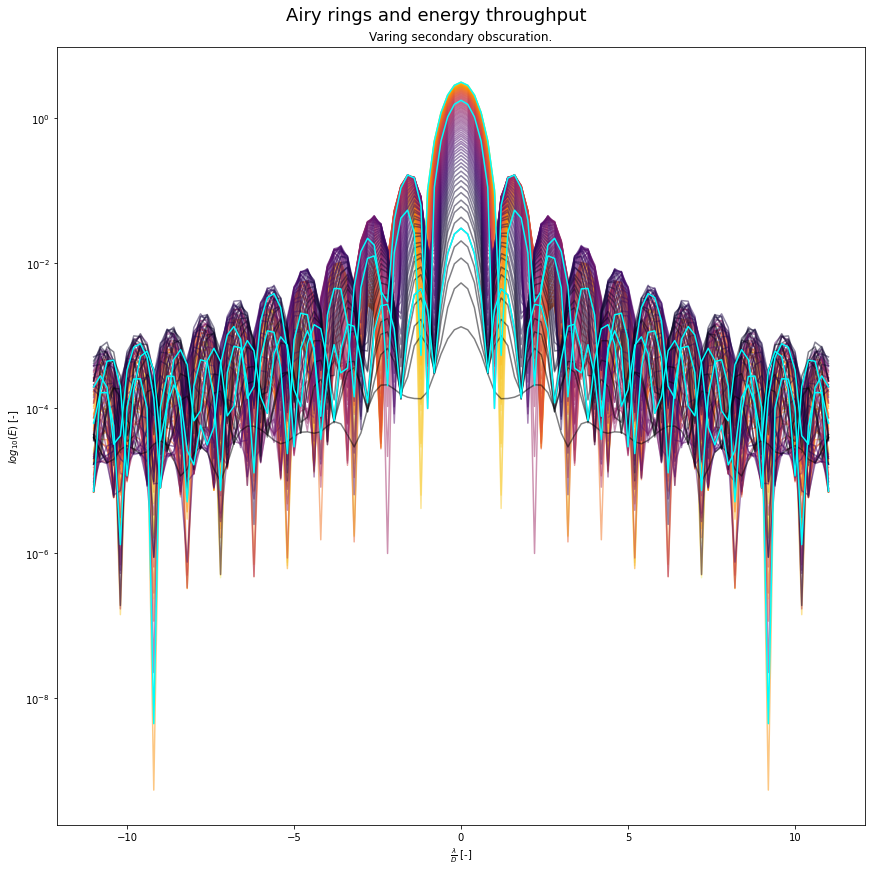

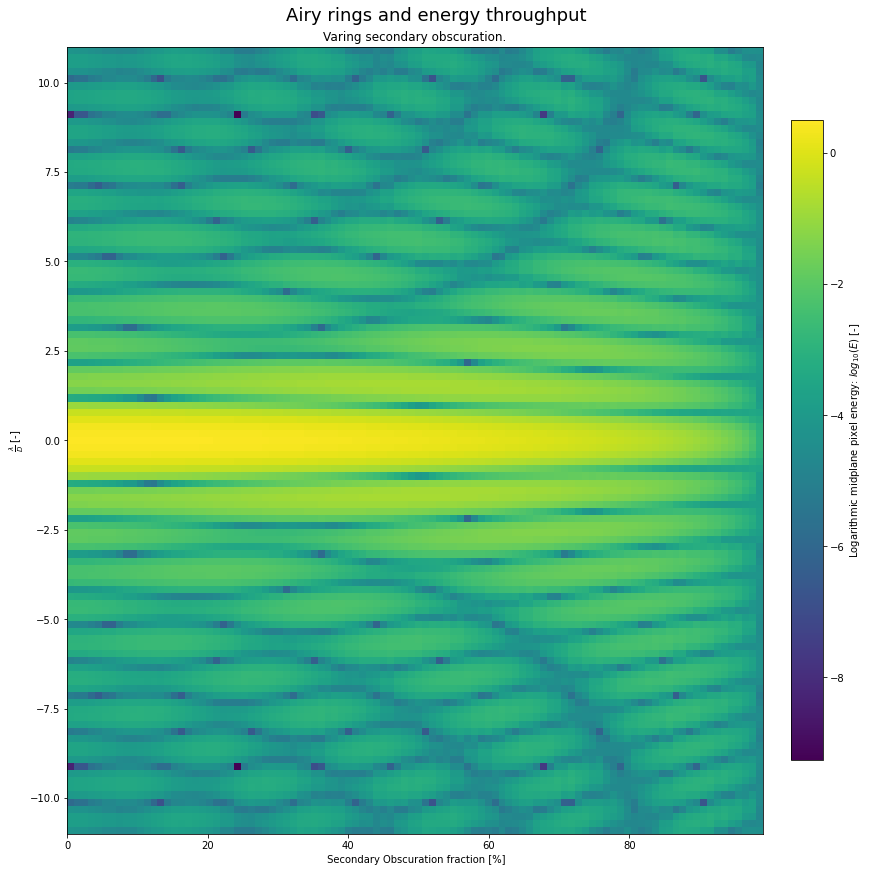

The realtive intensity of the first and second Airy ring maximum tends to unity. (The extreme is no longer properly resolved by the resolution we have in the focal plane. However, tis is of course trivillay true for the secondary obscuration fraction of 100%.)


In [6]:
# Q2 answer here
n = 11
fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))



fractions1 = np.linspace(0., 0.99, 100)
x = np.linspace(-n, n, 2 * n * nsamp + 1)

ff, rr = np.meshgrid(fractions1, x)

energy = np.zeros_like(ff)

color = iter(plt.cm.inferno(np.linspace(1, 0., len(fractions1))))
for i, frac in enumerate(fractions1):
    B_mask = 1 - circle_mask(phase, (dtel)/2, (dtel-1)/2, frac * dtel/2)
    E = A_n * B_mask *np.exp(1j*phase) 
    Edet = FFT(E, nsamp)
    ASF = np.abs(Edet) * np.abs(Edet)
    B = np.abs(ASF)
    Bn = np.sqrt(B / np.product(np.array(A_n.shape)*nsamp))
    
    
    en = xaxis_energy(Bn, n * nsamp)
    energy[:, i] = en
    ax.plot(x, en, c=next(color), alpha=0.5)

ax.plot(x, energy[:, 0], c="cyan")    
ax.plot(x, energy[:, 50], c="cyan")   
ax.plot(x, energy[:, 95], c="cyan")   

ax.set_yscale("log")
ax.set_title('Varing secondary obscuration.')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r"$log_{10}(E)$ [-]")
fig.suptitle('Airy rings and energy throughput', fontsize=18) 
plt.show()
    
energy = np.log10(energy)
fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

extent = [fractions1.min() , fractions1.max()* 100, x.min() , x.max()]
im = ax.imshow(energy, extent=extent, origin="lower", aspect="auto")
plt.colorbar(im, label="Logarithmic midplane pixel energy: "r"$log_{10}(E)$ [-]",
             fraction=0.046, pad=0.04,)
    
# ax.set_yscale("log")
ax.set_title('Varing secondary obscuration.')  
ax.set_ylabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_xlabel(r" Secondary Obscuration fraction [%]")
fig.suptitle('Airy rings and energy throughput', fontsize=18) 
plt.show()

print("The realtive intensity of the first and second Airy ring maximum tends to unity. (The extreme is no longer properly resolved by the resolution we have in the focal plane. However, tis is of course trivillay true for the secondary obscuration fraction of 100%.)")

# Q2 end of answer


---
<span style="  font-size:2em; color: SteelBlue;">Question 4.3</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Why do the diffraction minima not move significantly as the secondary obscuration increases?**

---

In [7]:
# Q3 answer here

print("Because the outer diameter of the telescope does not change.")

# Q3 end of answer

Because the outer diameter of the telescope does not change.


### Adding secondary support to our secondary obscuration

We just calculated the encircled energy resulting from secondary obscuration. As mentioned before, additional shadows are caused by secondary supports to the telescope pupil. 

In our telescope we have four struts equally spaced around the circumference of the telescope pupil. They are connecting the edges of the primary mirror to the secondary mirror. All four secondary mirror supports have a width of 5% of the telescope pupil's diameter.

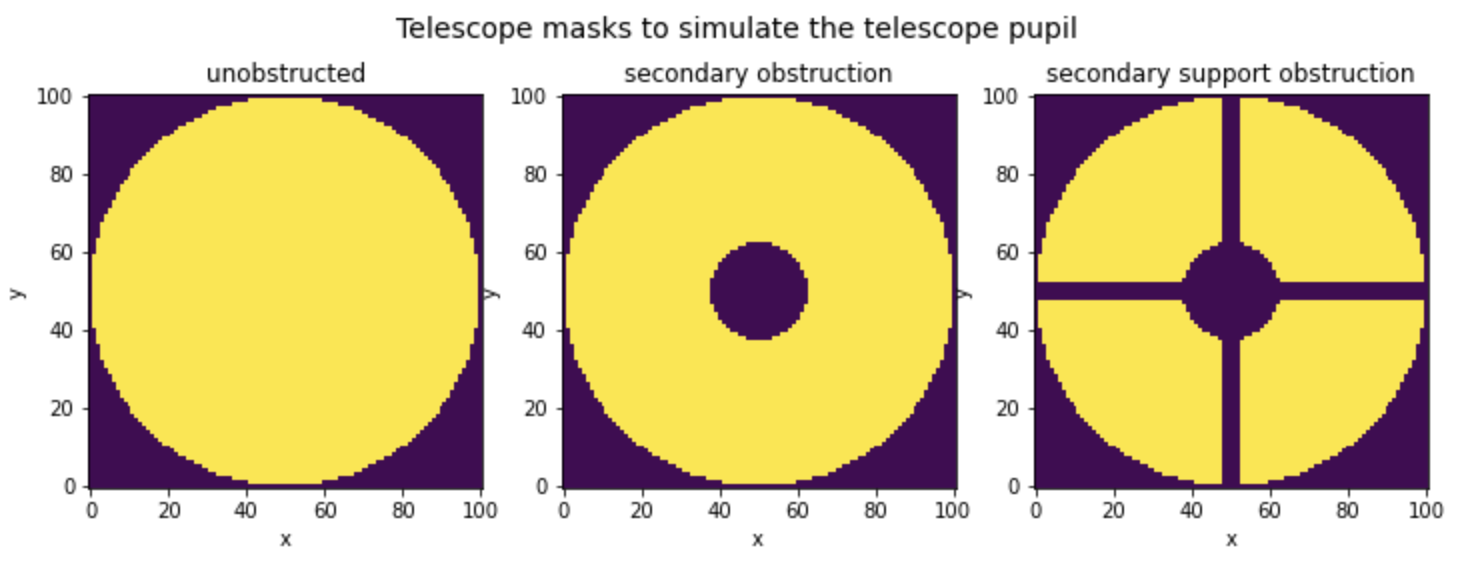

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.4</span> <span style="  font-size:1em; color: SteelBlue;">
(5 points): </span>

**Make three PSF images of the following pupils:**

1. **The unobstructed pupil**
* **A pupil with 25% secondary obscuration (thus, the diameter of the secondary obscuration is 25% of the diameter of the primary mirror)**
* **A pupil with 25% obscuration and the seconday supports described above.**

**Display their log10 signal using `plt.imshow(zoom(np.log10(psf_image / psf_image.max())))` while zooming in into the central 141 pixels and a lower value boundery of -5:**

**Answer the question: What is the effect of the secondary support structures in the PSF?**

---

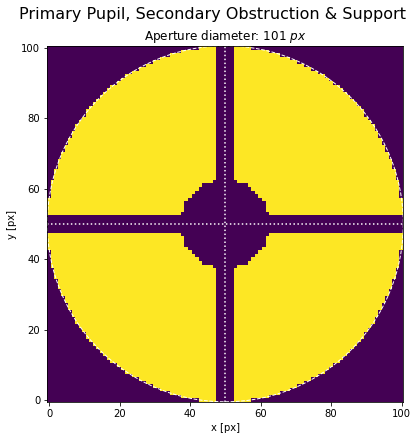

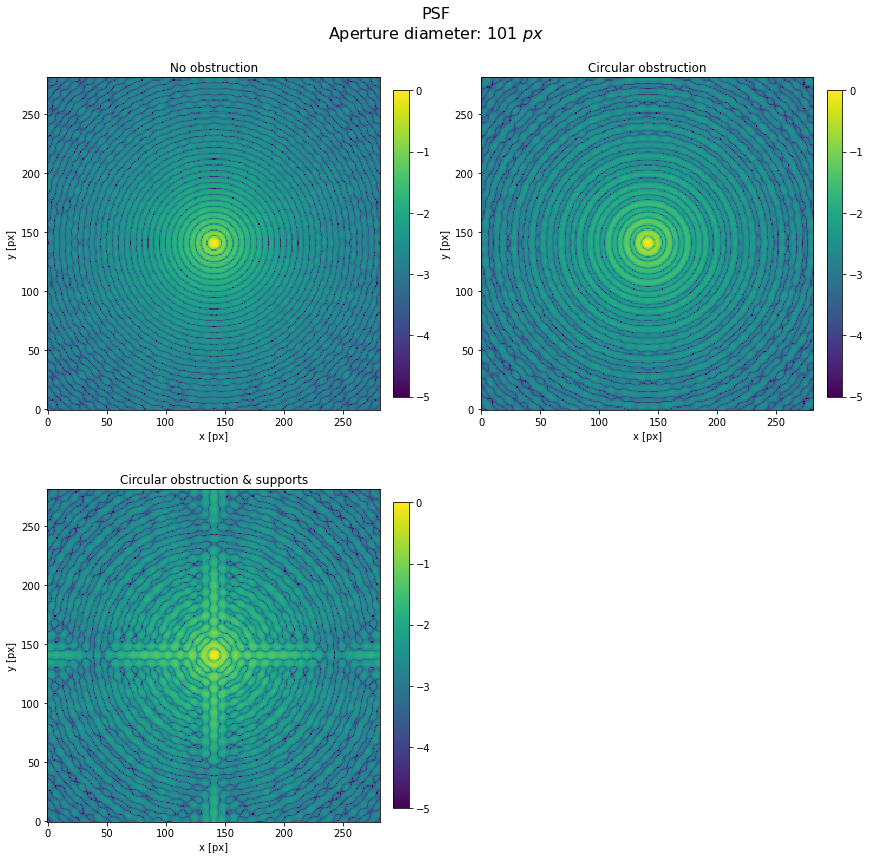

What is the effect of the secondary support structures in the PSF?

Since light diffracts around the supports the equivalent of a Poisson spot for rectangles appears 'behind' the supports. This looks like a cross in the PSF that extends to the outer diameter of the telescope. Outside the outer diameter of the telescope the cross pattern contnues due to the circular correlation of the FFT.


In [8]:
# code here

E = A_n * np.exp(1j*phase) 
Edet = FFT(E, nsamp)
ASF = np.abs(Edet) * np.abs(Edet)
B = np.abs(ASF)
B_1 = np.sqrt(B / np.product(np.array(A_n.shape)*nsamp))

B_mask = 1 - circle_mask(phase, (dtel-1)/2, (dtel-1)/2, 0.25 * dtel/2)
E = A_n * B_mask *np.exp(1j*phase) 
Edet = FFT(E, nsamp)
ASF = np.abs(Edet) * np.abs(Edet)
B = np.abs(ASF)
B_2 = np.sqrt(B / np.product(np.array(A_n.shape)*nsamp))

B_3 = 1 - circle_mask(phase, (dtel-1)/2, (dtel-1)/2, 0.25 * dtel/2)
B_3 = A_n * B_3
half_width = dtel * 0.05 / 2.
B_3[int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width), :] = 0 
B_3[:, int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width)] = 0 

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(6, 6))
im = plt.imshow(B_3.real)
ax.axvline((dtel-1)/2, c="w", ls="dotted")
ax.axhline((dtel-1)/2, c="w", ls="dotted")

p = mpl.patches.Circle(((dtel-1)/2, (dtel-1)/2), dtel/2, fc="none", ec="w", ls="dashed")
ax.add_artist(p)

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title(r'Aperture diameter: $101~px$') 
fig.suptitle(r'Primary Pupil, Secondary Obstruction & Support', fontsize=16)
plt.show()

E = B_3 * np.exp(1j*phase) 
Edet = FFT(E, nsamp)
ASF = np.abs(Edet) * np.abs(Edet)
B = np.abs(ASF)
B_3 = np.sqrt(B / np.product(np.array(A_n.shape)*nsamp))

fig, axes = plt.subplots(nrows=2, ncols=2,
                     constrained_layout=True,
                     figsize=(12, 12))
titles = ["No obstruction", 'Circular obstruction', "Circular obstruction & supports"]

for psf_image, ax, title in zip([B_1, B_2, B_3], np.array(axes).flatten(), titles):
    im = ax.imshow(zoom(np.log10(psf_image / psf_image.max()), trim=141), vmin=-5)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04,)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title(title) 

np.array(axes).flatten()[-1].axis('off') 
fig.suptitle(f'PSF\n'r'Aperture diameter: $101~px$', fontsize=16)
plt.show()



# Q4 answer here

print("What is the effect of the secondary support structures in the PSF?\n")
print("Since light diffracts around the supports the equivalent of a Poisson spot for rectangles appears 'behind' the supports. This looks like a cross in the PSF that extends to the outer diameter of the telescope. Outside the outer diameter of the telescope the cross pattern contnues due to the circular correlation of the FFT.")

# Q4 end of answer


<a id='part2'></a>

## More Coronagraphs and the effect of Secondary Obscurations

Last time, you saw that the Lyot coronagraph can suppress on-axis sources. This week, we will look at two other coronagraphs that are used in modern telescopes both on the ground and proposed for space missions. These are some of the *small angle coronagraphs* which can image planets and disks around stars at small angular separations.

### Type 1: Vortex (focal plane) coronagraph

Vortex focal plane coronagraphs are useful for potential imaging of terrestrial exoplanets in nearby solar systems when used on space-based telescopes. As the name reveals, they make use of vector vortex phase masks.

*How can we simulate a vortex coronagraph?*
In the focal plane mask `m`, a phase ramp is added. This ramp goes from 0 to $n \pi$ radians around a central point, where $n$ denotes the *order* of the vortex. The star is put on the central point of the vortex mask with the planet off to one side. 

A pupil mask `N` then masks out as much of the starlight as possible, while maximising the amount of planet light passing through to the final focal plane `F`. Thus for `N` you want to pick a mask that rejects the star flux but passes the planet flux.

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.5</span> <span style="  font-size:1em; color: SteelBlue;">
(3 points): </span>

**Display the on-axis transmission for the $n=4$ vortex coronagraph and off-axis transmission for a planet at $3 \lambda/D$ which is 10000 times fainter in intensity than the central star at position `D`.**

1. **Make a vortex mask `m` consisting of only zeroes. From `m` and `r_theta()` you will create your focal plane mask `m_vor`**
* **Create the circular pupil plane mask `N_vor`**
* **Make the star image, and calculate the vortex coronagraph for it**
* **Make the fainter planet**
* **Move the planet $3 \lambda/D$ and run the vortex coronagraph on the planet**
* **Display two images with `plotCAmpl(xxx,..)` of the inner 141 pixels:**
    * **(1) the pupil at position `D` in the vortex coronagraph for the star,**
    * **(2) the pupil at position `D` for the planet.** 
    
**Look at the differences. Answer the question: What has happened to the flux of the star and the planet in coronagraph plane `D`?**

<div class="alert alert-block alert-info">
<b>Sanity check:</b> In your display of <code>plotCAmpl(star,trim=151)</code> you should see changes in colours only towards the edges of the aperture. </div>

---


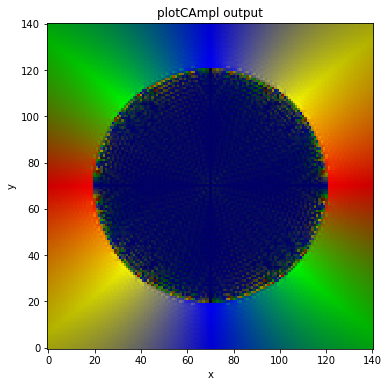

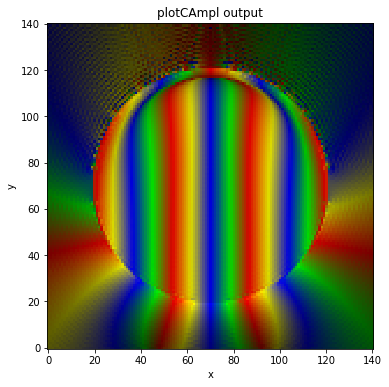

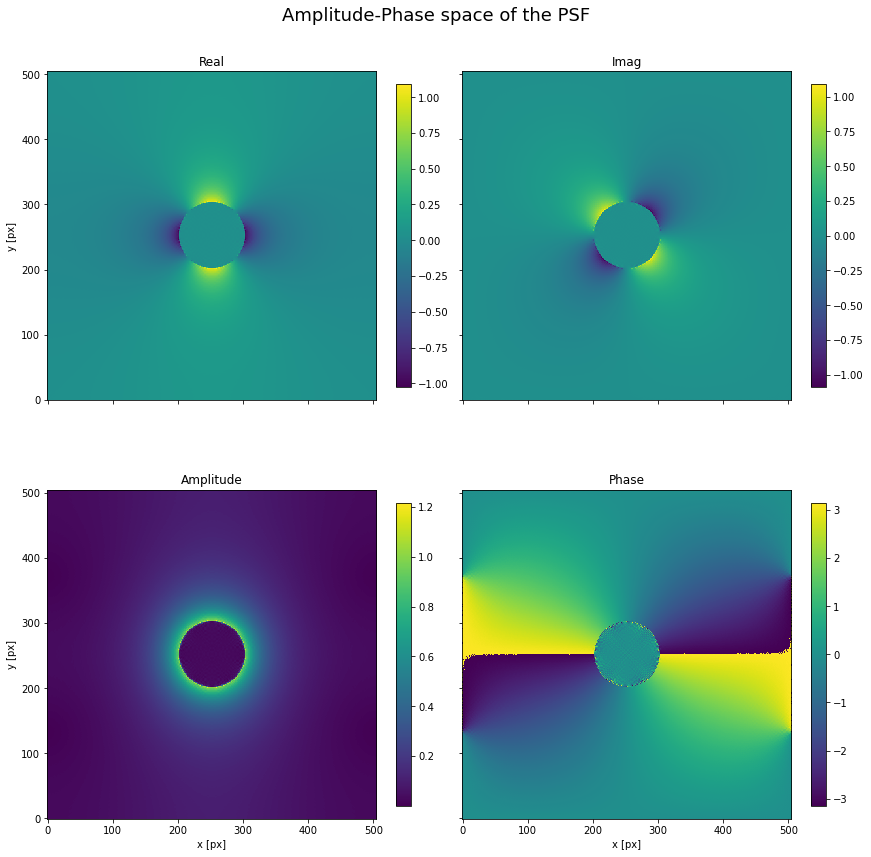

In [9]:
# Q5 code here
n = 4
m = np.zeros(np.array(phase.shape) * nsamp)
rr, phi = r_theta(m, (dtel * nsamp -1)/2 , (dtel * nsamp -1)/2 )
m_vor = (phi - phi.min()) / phi.max() * np.pi * n/2
m_vor = circle_mask(m, (len(m_vor)-1)//2, (len(m_vor)-1)//2, len(m_vor)/2) * np.exp(1j*m_vor)


rad = 45
N_vor = circle_mask(m_vor, (len(m_vor)-1)//2, (len(m_vor)-1)//2, rad)

Star = circle_mask(phase, (len(phase)-1)//2, (len(phase)-1)//2, (dtel)/2)

ramp_star = phi_ramp(phase, 0.0, 0)
A_star = Star * np.exp(1j*ramp_star)

Planet = Star.copy() / np.sqrt(10000)
ramp_planet = phi_ramp(phase, 3, 0)
A_planet = Planet * np.exp(1j*ramp_planet)


D_star = coro(A_star, m_vor, N_vor, nsamp)[2]
D_planet = coro(A_planet, m_vor, N_vor, nsamp)[2]

__ = plotCAmpl(D_star, trim=141)
__ = plotCAmpl(D_planet, trim=141)

displC(D_star)




# Q5 end of answer


In [10]:
print("Inside the pupil the star flux is masked out by phase shifting the incoming light and exploiting destructive interverence. Just some flux near the edge and almost all of the planet flux is preserved.")

Inside the pupil the star flux is masked out by phase shifting the incoming light and exploiting destructive interverence. Just some flux near the edge and almost all of the planet flux is preserved.



---
<span style="  font-size:2em; color: SteelBlue;">Question 4.6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Show that the star light is rejected by your Lyot pupil plane mask by plotting the cut across the PSF of both star and planet using the `xaxis_energy` from last weeks Practicum. In addition, also plot the star before the coronagraph in plane `B` to show how much starlight has been suppressed. Label the y-axis in `log10` units of normalised intensity, using the telescope PSF with no coronagraph from plane `B` as your reference PSF where the peak intensity is 1. Add a legend to distinguish the three plots.**

---



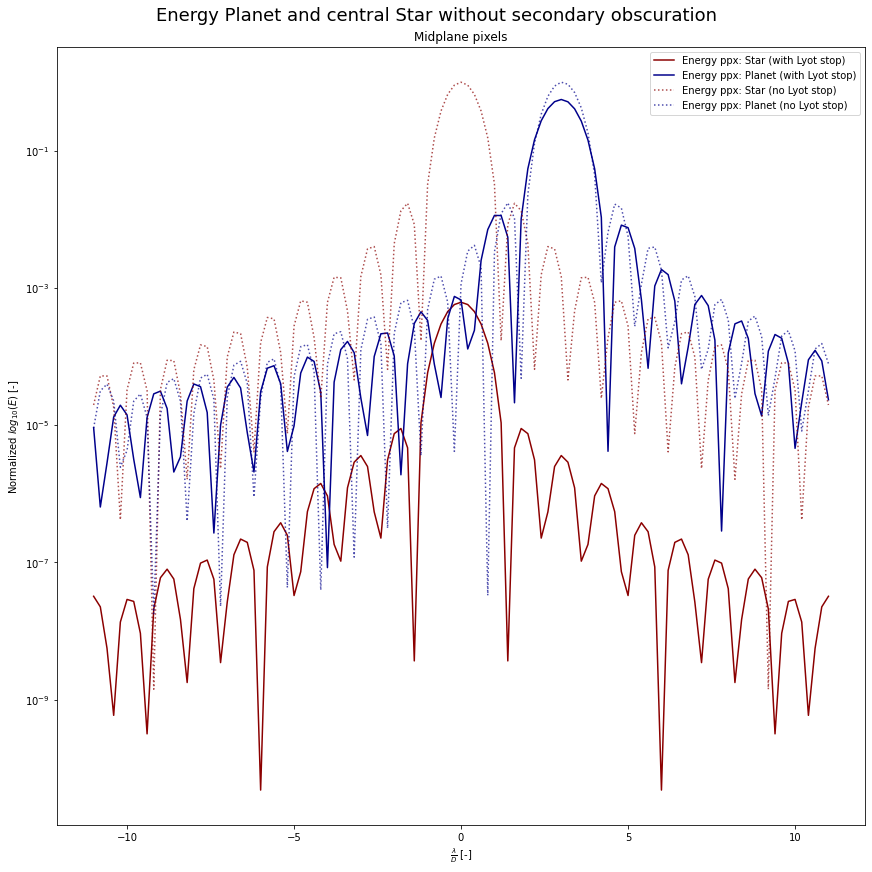

In [11]:
l_D = 11

Star = circle_mask(phase, (len(phase)-1)//2, (len(phase)-1)//2, (dtel)/2)

ramp_star = phi_ramp(phase, 0.0, 0)
A_star = Star * np.exp(1j*ramp_star)

Planet = Star.copy() / np.sqrt(10000)
ramp_planet = phi_ramp(phase, 3, 0)
A_planet = Planet * np.exp(1j*ramp_planet)


B_star = coro(A_star, m_vor, N_vor, nsamp)[0]
B_planet = coro(A_planet,  m_vor, N_vor, nsamp)[0]

E_star = xaxis_energy(B_star, l_D * nsamp) 
E_planet = xaxis_energy(B_planet, l_D * nsamp)

F_planet = coro(A_planet, m_vor, N_vor, nsamp)[4]
F_star = coro(A_star, m_vor, N_vor, nsamp)[4]

E_star_F = xaxis_energy(F_star,  l_D * nsamp)
E_planet_F = xaxis_energy(F_planet, l_D * nsamp)

x = np.linspace(-l_D, l_D, 2 * l_D * nsamp + 1)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(x, E_star_F / E_star.max(), label="Energy ppx: Star (with Lyot stop)", c="darkred")
ax.plot(x, E_planet_F / E_planet.max(), label="Energy ppx: Planet (with Lyot stop)", c="darkblue")

ax.plot(x, E_star / E_star.max(), label="Energy ppx: Star (no Lyot stop)", c="darkred", ls="dotted", alpha=0.7)
ax.plot(x, E_planet  / E_planet.max(), label="Energy ppx: Planet (no Lyot stop)", c="darkblue", ls="dotted", alpha=0.7)

# ax.set_ylim(0, None)
# ax.set_xlim(0, None)

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r"Normalized $log_{10}(E)$ [-]")
fig.suptitle('Energy Planet and central Star without secondary obscuration and vortex coronagrpha', fontsize=18) 
plt.show()


### Type 2: The Vortex coronagraph with a secondary obscuration

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.7</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Repeat the PSF plots from the previous question for the vortex coronagraph but with a 15% secondary obscuration in the telescope.**

---


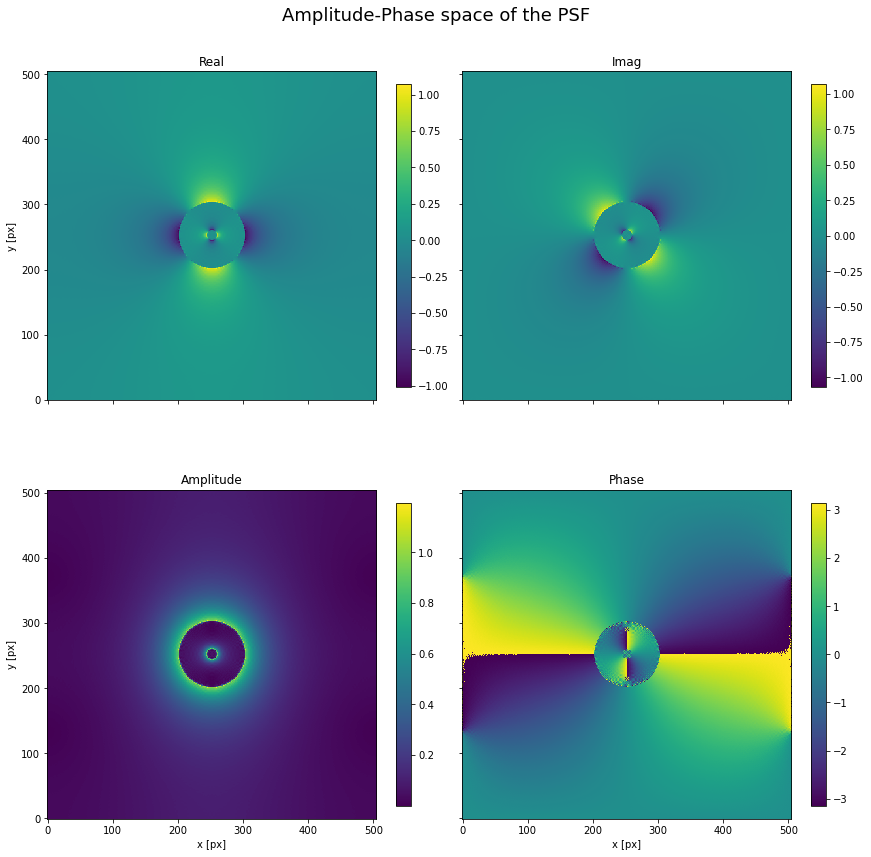

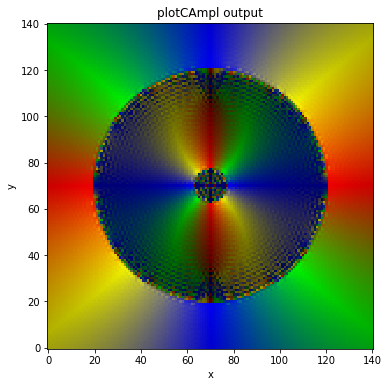

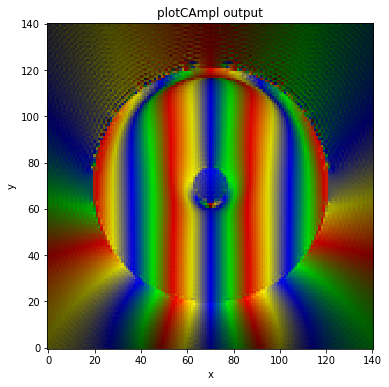

In [12]:
# Q7 code here

n = 4
m = np.zeros(np.array(phase.shape) * nsamp)
rr, phi = r_theta(m, (dtel * nsamp -1)/2 , (dtel * nsamp -1)/2 )
m_vor = (phi - phi.min()) / phi.max() * np.pi * n/2
m_vor = circle_mask(m, (len(m_vor)-1)//2, (len(m_vor)-1)//2, len(m_vor)/2) * np.exp(1j*m_vor)

rad = 45
N_vor = circle_mask(m_vor, (len(m_vor)-1)//2, (len(m_vor)-1)//2, rad)

Star = circle_mask(phase, (dtel-1)/2, (dtel-1)/2, dtel/2) * \
(1 - circle_mask(phase, (dtel-1)/2, (dtel-1)/2, 0.15 * dtel/2))

# half_width = dtel * 0.05 / 2.
# Star[int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width), :] = 0 
# Star[:, int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width)] = 0 

ramp_star = phi_ramp(phase, 0., 0)
A_star = Star * np.exp(1j*ramp_star)



Planet = Star.copy() / np.sqrt(10000)
ramp_planet = phi_ramp(phase, 3, 0)
A_planet = Planet * np.exp(1j*ramp_planet)


D_star = coro(A_star, m_vor, N_vor, nsamp)[2]
D_planet = coro(A_planet, m_vor, N_vor, nsamp)[2]

displC(D_star)

__ = plotCAmpl(D_star, trim=141)
__ = plotCAmpl(D_planet, trim=141)

# Q7 end of code


---
<span style="  font-size:2em; color: SteelBlue;">Question 4.8</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **Has the on-axis vortex coronagraph suppression increased or decreased?**

2. **What is the effect of the secondary obscuration in the Lyot stop plane?** Take a look at the results for the Lyot stop plane for multiple secondary obscuration. Describe your findings

---


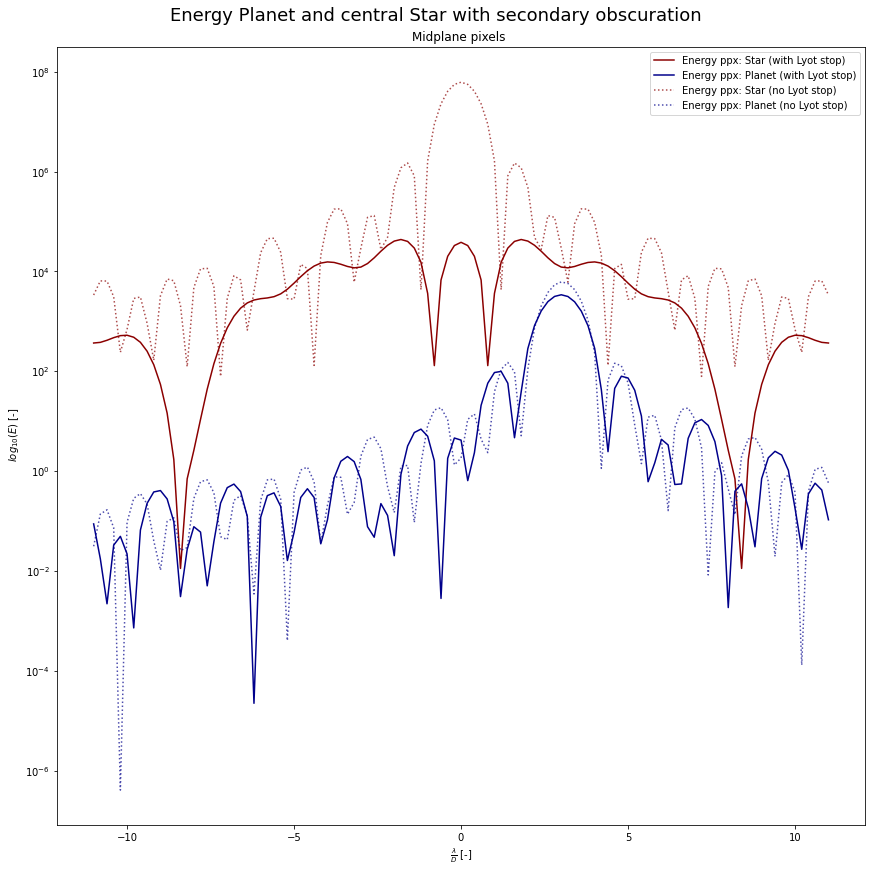

The on-axis vortex coronagraph supression has decreased, except (maybe) in the very center of the aperture.
This is especially visible when the flux amplitude is plotted: The secondary reflector diffracts light around its edge and so bypasses the vortex coronagraph.
The secondary obscuration offsets the supression we get by phase shifting the light by 90 degrees because it reintroduces light that has not been phase shifted.
This is very clear when the secondary obscuration is set to a large fraction (the phases inside the telescope pupil are shifted by 90 degress w.r.t. those on the outside).
 Alternatively this can also be seen when the supports are intorduced into the aperture again, see below:


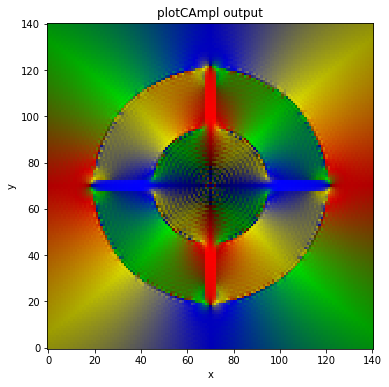

In [13]:
# Q8 answer here

ramp_star = phi_ramp(phase, 0.0, 0)
A_star = Star * np.exp(1j*ramp_star)

l_D = 11

B_star = coro(A_star, m_vor, N_vor, nsamp)[0]
B_planet = coro(A_planet,  m_vor, N_vor, nsamp)[0]

E_star = xaxis_energy(B_star, l_D * nsamp)
E_planet = xaxis_energy(B_planet, l_D * nsamp)

F_planet = coro(A_planet, m_vor, N_vor, nsamp)[4]
F_star = coro(A_star, m_vor, N_vor, nsamp)[4]

E_star_F = xaxis_energy(F_star,  l_D * nsamp)
E_planet_F = xaxis_energy(F_planet, l_D * nsamp)

x = np.linspace(-l_D, l_D, 2 * l_D * nsamp + 1)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(x, E_star_F, label="Energy ppx: Star (with Lyot stop)", c="darkred")
ax.plot(x, E_planet_F, label="Energy ppx: Planet (with Lyot stop)", c="darkblue")

ax.plot(x, E_star, label="Energy ppx: Star (no Lyot stop)", c="darkred", ls="dotted", alpha=0.7)
ax.plot(x, E_planet, label="Energy ppx: Planet (no Lyot stop)", c="darkblue", ls="dotted", alpha=0.7)

# ax.set_ylim(0, None)
# ax.set_xlim(0, None)

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels ')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r" $log_{10}(E)$ [-]")
fig.suptitle('Energy Planet and central Star with secondary obscuration and vortex coronagraph', fontsize=18) 
plt.show()


print("The on-axis vortex coronagraph supression has decreased, except (maybe) in the very center of the aperture."\
      "\nThis is especially visible when the flux amplitude is plotted: The secondary reflector diffracts light around its edge and so bypasses the vortex coronagraph.")
print("The secondary obscuration offsets the supression we get by phase shifting the light by 90 degrees because it reintroduces light that has not been phase shifted."\
     "\nThis is very clear when the secondary obscuration is set to a large fraction (the phases inside the telescope pupil are shifted by 90 degress w.r.t. those on the outside)."\
      "\n Alternatively this can also be seen when the supports are intorduced into the aperture again, see below:")

n = 4
m = np.zeros(np.array(phase.shape) * nsamp)
rr, phi = r_theta(m, (dtel * nsamp -1)/2 , (dtel * nsamp -1)/2 )
m_vor = (phi - phi.min()) / phi.max() * np.pi * n/2
m_vor = circle_mask(m, (len(m_vor)-1)//2, (len(m_vor)-1)//2, len(m_vor)/2) * np.exp(1j*m_vor)

rad = 45
N_vor = circle_mask(m_vor, (len(m_vor)-1)//2, (len(m_vor)-1)//2, rad)

Star_x = circle_mask(phase, (dtel-1)/2, (dtel-1)/2, dtel/2) * \
(1 - circle_mask(phase, (dtel-1)/2, (dtel-1)/2, 0.5 * dtel/2))

half_width = dtel * 0.05 / 2.
Star_x[int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width), :] = 0 
Star_x[:, int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width)] = 0 

A_star = Star_x * np.exp(1j*phase)


D_star = coro(A_star, m_vor, N_vor, nsamp)[2]

# displC(D_star)

__ = plotCAmpl(D_star, trim=141)
# Q8 end of answer

### Typ3: The APP Coronagraph

The Apodizing Phase Plate (APP) is not a coronagraph in the classical Lyot sense, but it is an apodizer that changes the electric field in the phase but not the amplitude. There is no focal plane mask `m` and you put it in the pupil plane `N`.



---
<span style="  font-size:2em; color: SteelBlue;">Question 4.9</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Calculate the same plots for star and planet for the APP coronagraph. The APP phase pattern is stored in `app_phse.fits` and the amplitude mask (a 33% secondary obscuration telescope pupil) is in `app_ampl.fits`.**

---



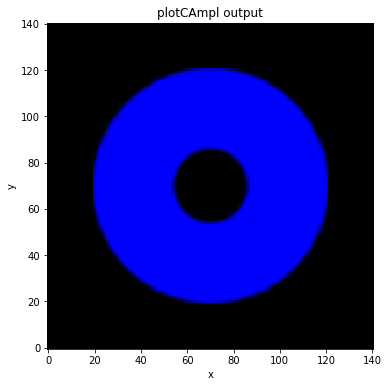

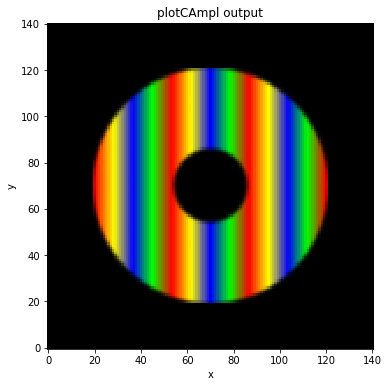

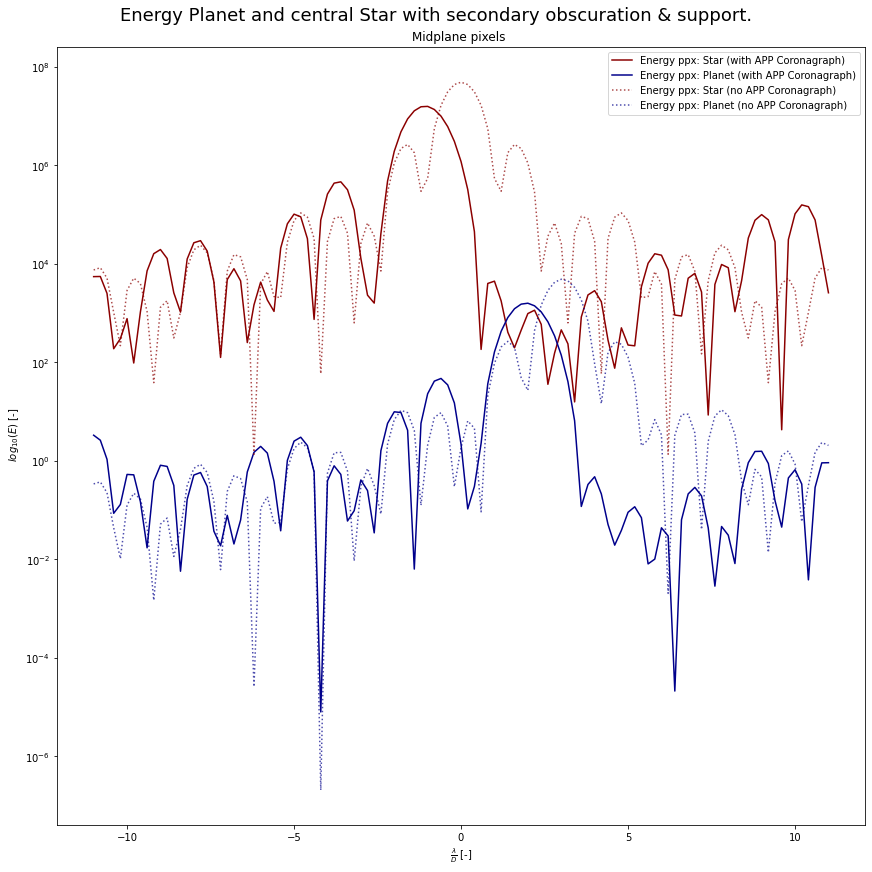

In [14]:
from astropy.io import fits

app_ampl, h1 = fits.getdata('app_ampl.fits',header=True)
app_phse, h2 = fits.getdata('app_phse.fits',header=True)

N_vor = padcplx(app_ampl * np.exp(1j*app_phse))

Star_app = app_ampl

# half_width = dtel * 0.05 / 2.
# Star_app[int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width), :] = 0 
# Star_app[:, int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width)] = 0 

ramp_star = phi_ramp(phase, 0.0, 0)
A_star = Star_app * np.exp(1j*ramp_star)


Planet = Star_app.copy() / np.sqrt(10000)
ramp_planet = phi_ramp(phase, 3, 0)
A_planet = Planet * np.exp(1j*ramp_planet)


D_star = coro(A_star, 1, N_vor, nsamp)[2]
D_planet = coro(A_planet, 1, N_vor, nsamp)[2]

# displC(D_star)

__ = plotCAmpl(D_star, trim=141)
__ = plotCAmpl(D_planet, trim=141)


# ================

B_star = coro(A_star, 1, N_vor, nsamp)[0]
B_planet = coro(A_planet, 1, N_vor, nsamp)[0]

E_star = xaxis_energy(B_star, l_D * nsamp)
E_planet = xaxis_energy(B_planet, l_D * nsamp)

F_planet = coro(A_planet, 1, N_vor, nsamp)[4]
F_star = coro(A_star, 1, N_vor, nsamp)[4]

E_star_F = xaxis_energy(F_star,  l_D * nsamp)
E_planet_F = xaxis_energy(F_planet, l_D * nsamp)

x = np.linspace(-l_D, l_D, 2 * l_D * nsamp + 1)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(x, E_star_F, label="Energy ppx: Star (with APP Coronagraph)", c="darkred")
ax.plot(x, E_planet_F, label="Energy ppx: Planet (with APP Coronagraph)", c="darkblue")

ax.plot(x, E_star, label="Energy ppx: Star (no APP Coronagraph)", c="darkred", ls="dotted", alpha=0.7)
ax.plot(x, E_planet, label="Energy ppx: Planet (no APP Coronagraph)", c="darkblue", ls="dotted", alpha=0.7)

# ax.set_ylim(0, None)
# ax.set_xlim(0, None)

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels ')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r" $log_{10}(E)$ [-]")
fig.suptitle('Energy Planet and central Star with secondary obscuration and AAP coronagraph.', fontsize=18) 
plt.show()

# Q9 end of answer

## Adding tip tilt error to the star

---
<span style="  font-size:2em; color: SteelBlue;">Question 4.10</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>

**Qualitatively describe what happens to the star flux in the Vortex and APP coronagraphs if you add $0.2 \lambda/D$ tilt in the x direction to the star's wavefront.**

**Answer the question: What does this (this = see what you need to describe) say about the tip tilt stability required for each of the coronagraphs?**


<div class="alert alert-block alert-info">
<b>TIP:</b> You can add the tilt in the code above, then comment it out again when you want the on-axis performance back. </div>

---

### Q10 answer here

Vortex coronagraph: Instead of the correct phase shift (all light has the same phase and destructively interferes) the phase is now shifted slightly (i.e. the propagation direction of th wavefront is no longer on-axis of the telescope). This means that the phase shifting that is performed by the vortex no longer reduces the amplitude at the focal plane to zero due to the change in path lengths. Instead it is shifted by the ramp slope and pad perpendicular to the ramp gradient in a positive direction (since the phase ramp gradient is positive). Even a small ramp produces large errors since the vortex has no axes of symmetry i.e. no matter what gradeint the ramp has there will always be errors. The errors become larger the larger the phase ramp is. Vortex coronagraphs with higher charge (two, four, ...) ramps along phi) can somewhat overcome this issue if they are well aligned with the phase ramp gradient.

AAP coronagraph: The effect is a phase ramp imprinted in the focal plane that is proportional to the phase ramp of the star. No real idea how people come up with the actual form of the surface but what I think it does is "collect" phases of beams close to each other and then preserve this information through the FFTs. Pretty cool. 
How the APP surface is then not "locked" into a compensating for a specific phase ramp/offset I have no idea but I am scared of the math for sure.

Clearly, the tilt stability that is required for vortex coronagraphs is much higher than for APP coronagraphs. One additional thing, the phase output of the APP has a clear gradient so I would expect it is both 1) easier to detect/compensate in post and 2) can probably quite easily be used to correct the pointing of the telescope if its pointing accuracy is good enough.

### Q10 end of answer


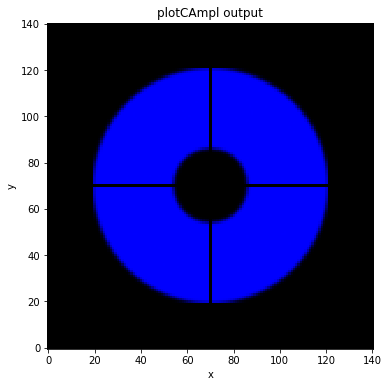

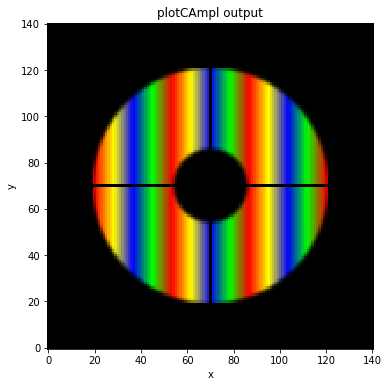

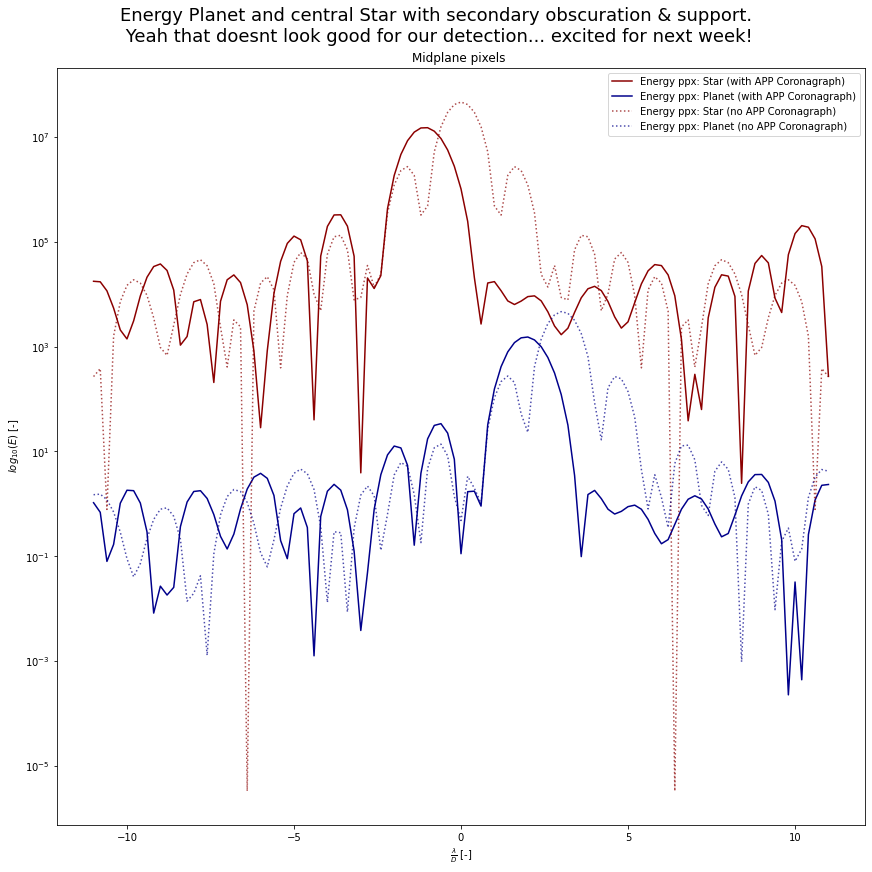

In [17]:
# How is it with a really thin suppor? Normally they are much smaller than one pixel but Im still excited to see how much worse this would make it.

N_vor = padcplx(app_ampl * np.exp(1j*app_phse))

Star_app = app_ampl

half_width = 0.5
Star_app[int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width), :] = 0 
Star_app[:, int(dtel/2 + 0.5 - half_width):int(dtel/2 + half_width)] = 0 

ramp_star = phi_ramp(phase, 0.0, 0)
A_star = Star_app * np.exp(1j*ramp_star)


Planet = Star_app.copy() / np.sqrt(10000)
ramp_planet = phi_ramp(phase, 3, 0)
A_planet = Planet * np.exp(1j*ramp_planet)


D_star = coro(A_star, 1, N_vor, nsamp)[2]
D_planet = coro(A_planet, 1, N_vor, nsamp)[2]

# displC(D_star)

__ = plotCAmpl(D_star, trim=141)
__ = plotCAmpl(D_planet, trim=141)


# ================

B_star = coro(A_star, 1, N_vor, nsamp)[0]
B_planet = coro(A_planet, 1, N_vor, nsamp)[0]

E_star = xaxis_energy(B_star, l_D * nsamp)
E_planet = xaxis_energy(B_planet, l_D * nsamp)

F_planet = coro(A_planet, 1, N_vor, nsamp)[4]
F_star = coro(A_star, 1, N_vor, nsamp)[4]

E_star_F = xaxis_energy(F_star,  l_D * nsamp)
E_planet_F = xaxis_energy(F_planet, l_D * nsamp)

x = np.linspace(-l_D, l_D, 2 * l_D * nsamp + 1)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12))

ax.plot(x, E_star_F, label="Energy ppx: Star (with APP Coronagraph)", c="darkred")
ax.plot(x, E_planet_F, label="Energy ppx: Planet (with APP Coronagraph)", c="darkblue")

ax.plot(x, E_star, label="Energy ppx: Star (no APP Coronagraph)", c="darkred", ls="dotted", alpha=0.7)
ax.plot(x, E_planet, label="Energy ppx: Planet (no APP Coronagraph)", c="darkblue", ls="dotted", alpha=0.7)

# ax.set_ylim(0, None)
# ax.set_xlim(0, None)

ax.set_yscale("log")
plt.legend()

ax.set_title('Midplane pixels ')  
ax.set_xlabel(r"$\frac{\lambda}{D}$ [-]")
ax.set_ylabel(r" $log_{10}(E)$ [-]")
fig.suptitle('Energy Planet and central Star with secondary obscuration & support.\n Yeah that doesnt look good for our detection... excited for next week!', fontsize=18) 
plt.show()



<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it!</div>


---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


In [15]:
# Number of hours taken for this practicum:
# Worked from 10 until 18:00 at the time of wrinting with ca 2ish h of break I think
# 6h total